# IS-4100 Lab: Predicting NFL Team Performance Using Multiple Linear Regression (MLR)

## Objective
In this lab, you will build a multiple linear regression model to predict a team's **points scored** in a game based on various features like offensive and defensive stats from both past and current NFL seasons.

## Dataset
- Use the `nfl_data_py` or `nflreadR` package to gather NFL data from past seasons (e.g., 2019-2023) and current in-season data.
- Some key features you could look at: passing yards, rushing yards, turnovers, penalties, possession time, and team win-loss record.

## Steps

### 1. Data Preparation
- Load and clean the dataset using `nfl_data_py` or `nflreadR`. Ensure that data from both past and current seasons is available.
- Create new features, such as averaging offensive and defensive statistics over the last 3-5 games.
- Handle missing values and ensure that the data is ready for analysis.

### 2. Feature Selection
- Identify key predictors of **points scored** for each game.
- Choose at least 5-7 features, such as:
  - Passing Yards
  - Rushing Yards
  - Turnovers
  - Penalties
  - Possession Time
  - Win-Loss Record

### 3. Model Construction
- Construct a **multiple linear regression** model to predict the number of points scored by a team.
- Use statistical tests (e.g., p-values) to evaluate the significance of each predictor.
- Analyze the coefficients to understand the contribution of each feature.

### 4. Model Evaluation
- Split the dataset into **training** and **testing** sets (e.g., 80/20 split).
- Calculate evaluation metrics for your model:
  - R² (coefficient of determination)
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
- Compare the performance of your multiple regression model to a simple baseline.

### 5. Comparison with Simple Linear Regression
- Build a simple linear regression model that uses only **total yards gained** as the predictor.
- Compare the results of this model with the multiple linear regression model in terms of performance metrics (R², MAE, RMSE).

### 6. In-Season Prediction
- Use your model with current in-season data to predict the outcome of upcoming NFL games.
- After the games are played, compare your model’s predictions with the actual results.

## Deliverables
- A written report summarizing:
  - Model development process
  - Feature selection and their importance
  - Model performance using evaluation metrics
  - Comparisons between multiple and simple linear regression models
- Visualizations, including:
  - Residual plots
  - Predicted vs. Actual points plots
- Insights on how well your model generalizes to the current season.

## Extra Hint
I'd recommend using the data dictionary that can be found [here](https://nflreadr.nflverse.com/articles/dictionary_pbp.html) to help with understanding and looking up various variables.

In [ ]:
## Environment Setup
!pip install nfl_data_py
import numpy as np
import pandas as pd
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
pbp_2024 = nfl.import_pbp_data([2024])

2024 done.
Downcasting floats.


## Offensive Yards/Play

In [ ]:
# Pulls all valid plays
valid_pbp = pbp_2024[
    (
        (pbp_2024['play_type'] == 'run') &
        (pbp_2024['rusher_id'].notnull()) &
        (pbp_2024['down'].notnull()) &
        (pbp_2024['run_location'].notnull())
    )
    |
    (
        (pbp_2024['play_type'] == 'pass') &
        (pbp_2024['passer_id'].notnull()) &
        (pbp_2024['down'].notnull()) &
        (pbp_2024['pass_location'].notnull())
    )
]

# Calculates yards gained and plays ran using NamedAgg
team_game_stats = valid_pbp.groupby(['posteam', 'game_id']).agg(
    total_yards = pd.NamedAgg(column='yards_gained', aggfunc='sum'),
    total_plays = pd.NamedAgg(column='play_id', aggfunc='count')
).reset_index()

# Calculates yards/play for each individual game
team_game_stats['yards_per_play'] = team_game_stats['total_yards'] / team_game_stats['total_plays']

# Sorts games by date, then uses the tail function to select the last 3 games
team_game_stats = team_game_stats.sort_values(by=['posteam', 'game_id'])
team_last_3_games = team_game_stats.groupby('posteam').tail(3)

# Calculates each teams' average yards per play using NamedAgg function
team_avg_yards_per_play = team_last_3_games.groupby('posteam').agg(
    avg_yards_per_play = pd.NamedAgg(column='yards_per_play', aggfunc='mean')
).reset_index()

# Add a rank column
team_avg_yards_per_play = team_avg_yards_per_play.sort_values(by='avg_yards_per_play', ascending=False)
team_avg_yards_per_play['rank'] = team_avg_yards_per_play['avg_yards_per_play'].rank(ascending=False, method='min').astype(int)

print(team_avg_yards_per_play)

   posteam  avg_yards_per_play  rank
2      BAL            7.753729     1
6      CIN            7.104688     2
28      SF            7.044509     3
10     DET            7.007804     4
27     SEA            6.929981     5
31     WAS            6.903287     6
1      ATL            6.734359     7
13     IND            6.623696     8
11      GB            6.561233     9
12     HOU            6.435569    10
14     JAX            6.422464    11
8      DAL            6.316206    12
25     PHI            6.221527    13
29      TB            6.154549    14
4      CAR            6.051436    15
5      CHI            6.003591    16
0      ARI            5.995912    17
16      LA            5.967415    18
15      KC            5.957306    19
26     PIT            5.879459    20
18      LV            5.736456    21
23     NYG            5.702882    22
20     MIN            5.636218    23
30     TEN            5.391568    24
17     LAC            5.271538    25
3      BUF            5.179725    26
9

## Defensive Yards Allowed/Play

In [ ]:
# Calculates yards gained and plays ran using pandas NamedAgg function
team_game_stats = valid_pbp.groupby(['defteam', 'game_id']).agg(
    total_yards = pd.NamedAgg(column='yards_gained', aggfunc='sum'), # Offensive Yards gained
    total_plays = pd.NamedAgg(column='play_id', aggfunc='count') # Offensive plays ran
).reset_index()

# Calculates yards/play for each individual game
team_game_stats['yards_per_play'] = team_game_stats['total_yards'] / team_game_stats['total_plays']

# Sorts games by date, then uses the tail function to select the last 3 games
team_game_stats = team_game_stats.sort_values(by=['defteam', 'game_id'])
team_last_3_games = team_game_stats.groupby('defteam').tail(3)

# Calculates each teams' average yards per play using pandas NamedAgg function
team_avg_yards_per_playD = team_last_3_games.groupby('defteam').agg(
    avg_yards_per_playD = pd.NamedAgg(column='yards_per_play', aggfunc='mean')
).reset_index()
team_avg_yards_per_playD = team_avg_yards_per_playD.sort_values(
    by='avg_yards_per_playD', ascending=True)

team_avg_yards_per_playD= team_avg_yards_per_playD.sort_values(by='avg_yards_per_playD', ascending=True)
team_avg_yards_per_playD['rank'] = team_avg_yards_per_playD['avg_yards_per_playD'].rank(ascending=True, method='min').astype(int)

print(team_avg_yards_per_playD)

   defteam  avg_yards_per_playD  rank
24     NYJ             4.332641     1
9      DEN             5.008765     2
15      KC             5.041303     3
12     HOU             5.164871     4
30     TEN             5.252096     5
17     LAC             5.512326     6
20     MIN             5.599401     7
1      ATL             5.703357     8
28      SF             5.731235     9
19     MIA             5.743797    10
8      DAL             5.813933    11
23     NYG             5.843464    12
7      CLE             5.945909    13
26     PIT             5.965242    14
10     DET             6.101754    15
25     PHI             6.108608    16
18      LV             6.124918    17
31     WAS             6.180498    18
5      CHI             6.200421    19
11      GB             6.217276    20
29      TB             6.226944    21
2      BAL             6.286919    22
4      CAR             6.297187    23
3      BUF             6.362160    24
16      LA             6.403552    25
0      ARI  

<Figure size 1000x600 with 0 Axes>

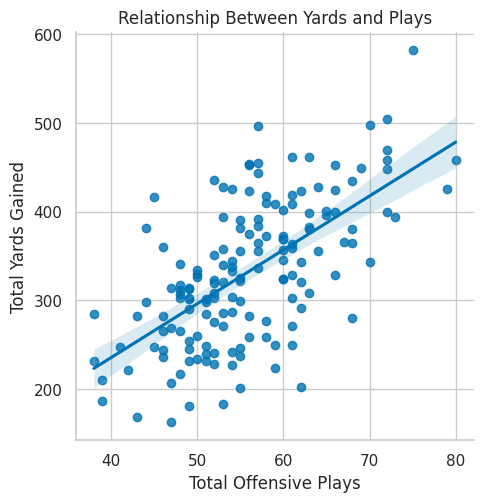

In [ ]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.lmplot(x='total_plays', y='total_yards', data=team_game_stats)

plt.xlabel('Total Offensive Plays')
plt.ylabel('Total Yards Gained')
plt.title('Relationship Between Yards and Plays')

plt.show()

##**Model Factors**##
- Passing Yards
- Rushing Yards
- Plays
- Turnovers (INT + Fumbles)
- Sacks Allowed


In [ ]:
# Load play-by-play data
seasons = range(2016,2024,+1)

pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


##Points Scored per Game

In [ ]:
all_valid_pbp = pbp[
    (
        (pbp['play_type'] == 'run') &
        (pbp['rusher_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['run_location'].notnull())
    )
    |
    (
        (pbp['play_type'] == 'pass') &
        (pbp['passer_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['pass_location'].notnull())
    )
]

# Grabs the last row of a game, which contains the final score
final_scores = all_valid_pbp.drop_duplicates(subset=['game_id', 'posteam'], keep='last')

# Gets the final points scored for each team in each game
team_points_scored = final_scores.groupby(['posteam', 'game_id']).agg(
    points_scored = pd.NamedAgg(column='posteam_score', aggfunc='last')
).reset_index()

print(team_points_scored[['posteam', 'game_id', 'points_scored']])

     posteam          game_id  points_scored
0        ARI   2016_01_NE_ARI           21.0
1        ARI   2016_02_TB_ARI           40.0
2        ARI  2016_03_ARI_BUF           18.0
3        ARI   2016_04_LA_ARI           13.0
4        ARI   2016_05_ARI_SF           31.0
...      ...              ...            ...
4377     WAS  2023_13_MIA_WAS           15.0
4378     WAS   2023_15_WAS_LA           14.0
4379     WAS  2023_16_WAS_NYJ           28.0
4380     WAS   2023_17_SF_WAS           10.0
4381     WAS  2023_18_DAL_WAS           10.0

[4382 rows x 3 columns]


## Passing Yards per Game

In [ ]:
# Valid Passes only
valid_pass_pbp = pbp[
    (
        (pbp['play_type'] == 'pass') &
        (pbp['passer_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['pass_location'].notnull())
    )
]

# Finds the total passing yards for each posteam in each game
team_passing_yards = valid_pass_pbp.groupby(['posteam', 'game_id']).agg(
    total_passing_yards = pd.NamedAgg(column='yards_gained', aggfunc='sum')
).reset_index()

print(team_passing_yards)

     posteam          game_id  total_passing_yards
0        ARI   2016_01_NE_ARI                271.0
1        ARI   2016_02_TB_ARI                315.0
2        ARI  2016_03_ARI_BUF                287.0
3        ARI   2016_04_LA_ARI                325.0
4        ARI   2016_05_ARI_SF                124.0
...      ...              ...                  ...
4377     WAS  2023_13_MIA_WAS                127.0
4378     WAS   2023_15_WAS_LA                226.0
4379     WAS  2023_16_WAS_NYJ                156.0
4380     WAS   2023_17_SF_WAS                169.0
4381     WAS  2023_18_DAL_WAS                157.0

[4382 rows x 3 columns]


## Rushing Yards per Game

In [ ]:
# only valid run plays
valid_rush_pbp = pbp[
    (
        (pbp['play_type'] == 'run') &
        (pbp['rusher_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['run_location'].notnull())
    )
]

# finds the total rushing yards for each posteam in each game
team_rushing_yards = valid_rush_pbp.groupby(['posteam', 'game_id']).agg(
    total_rushing_yards = pd.NamedAgg(column='yards_gained', aggfunc='sum')
).reset_index()

print(team_rushing_yards)

     posteam          game_id  total_rushing_yards
0        ARI   2016_01_NE_ARI                 92.0
1        ARI   2016_02_TB_ARI                105.0
2        ARI  2016_03_ARI_BUF                 88.0
3        ARI   2016_04_LA_ARI                118.0
4        ARI   2016_05_ARI_SF                174.0
...      ...              ...                  ...
4377     WAS  2023_13_MIA_WAS                118.0
4378     WAS   2023_15_WAS_LA                 48.0
4379     WAS  2023_16_WAS_NYJ                 92.0
4380     WAS   2023_17_SF_WAS                 62.0
4381     WAS  2023_18_DAL_WAS                 47.0

[4382 rows x 3 columns]


## Total Plays per Game

In [ ]:
# finds the total offensive plays ran by each posteam in each game
team_total_plays = all_valid_pbp.groupby(['posteam', 'game_id']).agg(
    total_plays = pd.NamedAgg(column='play_id', aggfunc='count')
).reset_index()

print(team_total_plays)

     posteam          game_id  total_plays
0        ARI   2016_01_NE_ARI           55
1        ARI   2016_02_TB_ARI           64
2        ARI  2016_03_ARI_BUF           71
3        ARI   2016_04_LA_ARI           69
4        ARI   2016_05_ARI_SF           63
...      ...              ...          ...
4377     WAS  2023_13_MIA_WAS           48
4378     WAS   2023_15_WAS_LA           52
4379     WAS  2023_16_WAS_NYJ           56
4380     WAS   2023_17_SF_WAS           42
4381     WAS  2023_18_DAL_WAS           43

[4382 rows x 3 columns]


## Turnovers per Game

In [ ]:
# only plays with a turnover (INT or a fumble lost)
turnovers_pbp = pbp[(pbp['interception'] == 1)
|
(pbp['fumble_lost'] == 1)]

# finds the number of INT's thrown & fumbles lost by a posteam in each game
team_turnovers = turnovers_pbp.groupby(['posteam', 'game_id']).agg(
    interceptions = pd.NamedAgg(column='interception', aggfunc='sum'),
    fumbles_lost = pd.NamedAgg(column='fumble_lost', aggfunc='sum')
).reset_index()

# Sums together INT's & Fumbles to populate the total_turnovers column
team_turnovers['total_turnovers'] = team_turnovers['interceptions'] + team_turnovers['fumbles_lost']

print(team_turnovers[['posteam', 'game_id', 'total_turnovers', 'interceptions', 'fumbles_lost']])

     posteam          game_id  total_turnovers  interceptions  fumbles_lost
0        ARI  2016_03_ARI_BUF              5.0            4.0           1.0
1        ARI   2016_04_LA_ARI              5.0            3.0           2.0
2        ARI  2016_08_ARI_CAR              2.0            1.0           1.0
3        ARI   2016_10_SF_ARI              5.0            2.0           3.0
4        ARI  2016_11_ARI_MIN              2.0            2.0           0.0
...      ...              ...              ...            ...           ...
3142     WAS  2023_13_MIA_WAS              1.0            1.0           0.0
3143     WAS   2023_15_WAS_LA              1.0            1.0           0.0
3144     WAS  2023_16_WAS_NYJ              2.0            2.0           0.0
3145     WAS   2023_17_SF_WAS              2.0            2.0           0.0
3146     WAS  2023_18_DAL_WAS              3.0            2.0           1.0

[3147 rows x 5 columns]


## Sacks Allowed per Game

In [ ]:
# only plays with a sack
sacks_pbp = pbp[pbp['sack'] == 1]

# finds the number of sacks given up by a posteam in each game
team_sacks_allowed = sacks_pbp.groupby(['posteam', 'game_id']).agg(
    sacks_allowed = pd.NamedAgg(column='sack', aggfunc='sum')
).reset_index()

print(team_sacks_allowed[['posteam', 'game_id', 'sacks_allowed']])

     posteam          game_id  sacks_allowed
0        ARI   2016_01_NE_ARI            3.0
1        ARI   2016_02_TB_ARI            1.0
2        ARI  2016_03_ARI_BUF            5.0
3        ARI   2016_04_LA_ARI            3.0
4        ARI   2016_05_ARI_SF            1.0
...      ...              ...            ...
3845     WAS  2023_13_MIA_WAS            3.0
3846     WAS   2023_15_WAS_LA            1.0
3847     WAS  2023_16_WAS_NYJ            1.0
3848     WAS   2023_17_SF_WAS            1.0
3849     WAS  2023_18_DAL_WAS            4.0

[3850 rows x 3 columns]


##**MLR Model**##

In [ ]:
# Merge my created columns together to create the model
merged_pbp = team_points_scored.merge(team_passing_yards, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_rushing_yards, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_total_plays, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_turnovers, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_sacks_allowed, on=['posteam', 'game_id'], how='inner')

In [ ]:
# MLR Model creation
points_scored_model = smf.ols(
    data = merged_pbp,
    formula = 'points_scored ~ total_passing_yards + total_rushing_yards + total_plays + total_turnovers + sacks_allowed'
).fit()

print(points_scored_model.summary())

                            OLS Regression Results                            
Dep. Variable:          points_scored   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     473.7
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        02:12:09   Log-Likelihood:                -9452.8
No. Observations:                2816   AIC:                         1.892e+04
Df Residuals:                    2810   BIC:                         1.895e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1988    

**For every additional _____, a team is expected to score about about...**
- Passing Yard: 0.07 points
- Rushing Yard: 0.10 points
- Play ran: -0.14 points
- Turnover: -1.36 Points
- Sack Allowed: -0.77 Points

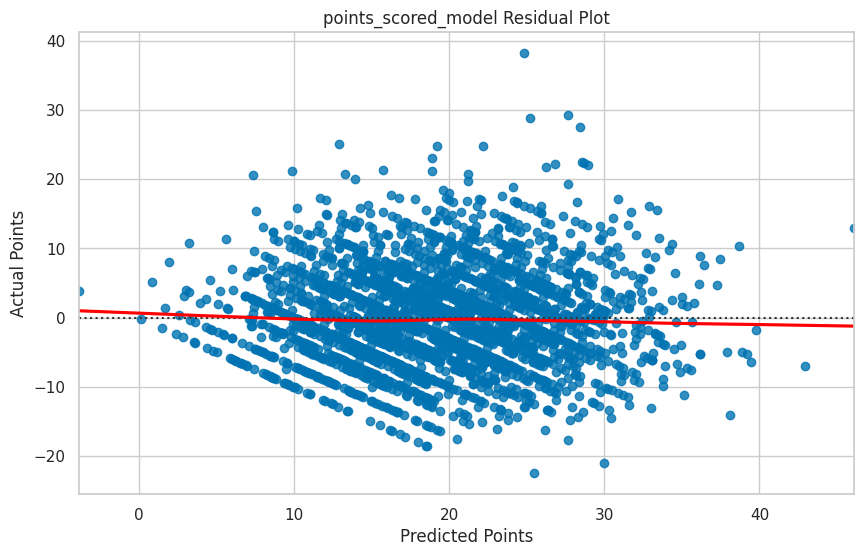

In [ ]:
# pull the fitted values and the residuals from model
fit = points_scored_model.fittedvalues
resid = points_scored_model.resid

plt.figure(figsize=(10, 6))
sns.residplot(x=fit, y=resid, lowess=True, line_kws={'color': 'red'})

plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')
plt.title('points_scored_model Residual Plot')
plt.show()

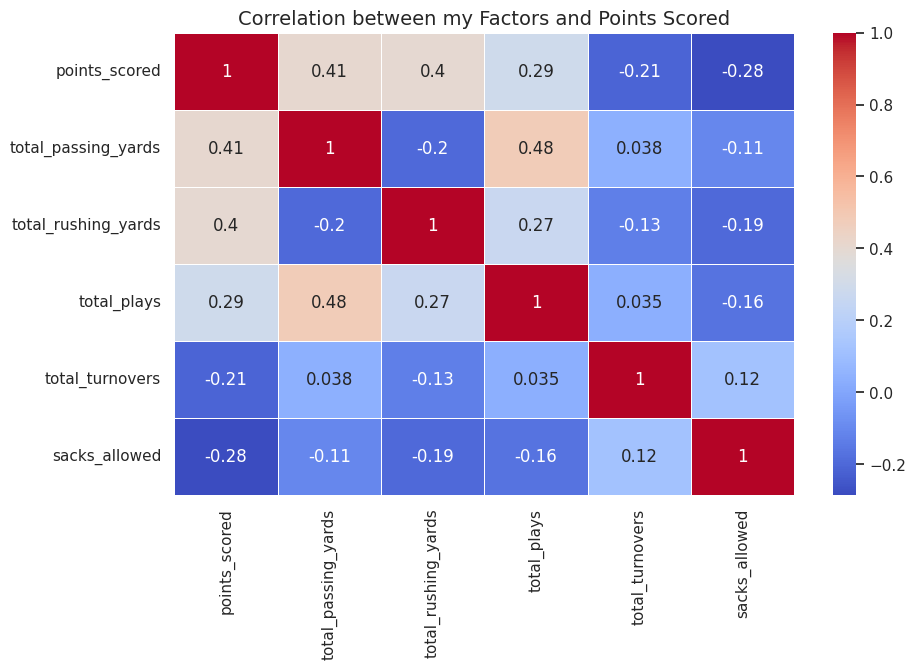

In [ ]:
# Create correlation matrix
corr_matrix = merged_pbp[['points_scored', 'total_passing_yards', 'total_rushing_yards', 'total_plays', 'total_turnovers', 'sacks_allowed']].corr()

# Crate heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation between my Factors and Points Scored', fontsize=14)
plt.show()

## Model Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Splitting the dataset into 80% training and 20% testing
train_data, test_data = train_test_split(merged_pbp, test_size=0.2, random_state=42)

# Fit the model on the training data
train_model = smf.ols(
    formula='points_scored ~ total_passing_yards + total_rushing_yards + total_plays + total_turnovers + sacks_allowed',
    data=train_data
).fit()

# Predict on the test set
test_data['predicted_points'] = train_model.predict(test_data)

# R-squared
r_squared = train_model.rsquared

# MAE
mae = mean_absolute_error(test_data['points_scored'], test_data['predicted_points'])

# RMSE
rmse = np.sqrt(mean_squared_error(test_data['points_scored'], test_data['predicted_points']))

# Baseline model: Predicting the mean points scored for all test set data
baseline_mean = train_data['points_scored'].mean()
test_data['baseline_prediction'] = baseline_mean

# Calculate MAE and RMSE for the baseline model
baseline_mae = mean_absolute_error(test_data['points_scored'], test_data['baseline_prediction'])
baseline_rmse = np.sqrt(mean_squared_error(test_data['points_scored'], test_data['baseline_prediction']))

# Print out the evaluation metrics
print(f"R-Squared: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"BL MAE: {baseline_mae}")
print(f"BL RMSE: {baseline_rmse}")

R-Squared: 0.4683396617147455
Mean Absolute Error: 5.4719482731307005
Root Mean Squared Error: 7.011578699358045
BL MAE: 7.259082317352295
BL RMSE: 9.122527122497559


- The Regression Model performs notably better than the baseline model

##**Linear Regression Model (Points Scored ~ Total Yards Gained)**##

In [ ]:
merged_pbp['total_yards_gained'] = merged_pbp['total_passing_yards'] + merged_pbp['total_rushing_yards']

# Linear Regression Model for points scored ~ total yards gained
yards_to_points = smf.ols(
    formula = 'points_scored ~ total_yards_gained',
    data = merged_pbp
).fit()

print(yards_to_points.summary())

                            OLS Regression Results                            
Dep. Variable:          points_scored   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1718.
Date:                Wed, 09 Oct 2024   Prob (F-statistic):          1.72e-293
Time:                        02:12:11   Log-Likelihood:                -9642.7
No. Observations:                2816   AIC:                         1.929e+04
Df Residuals:                    2814   BIC:                         1.930e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.4727      0

For every additional yard gained, a team is expected to score an additional 0.07 points

- (This tracks with my MLR model when you look at passing yards & rushing yards)

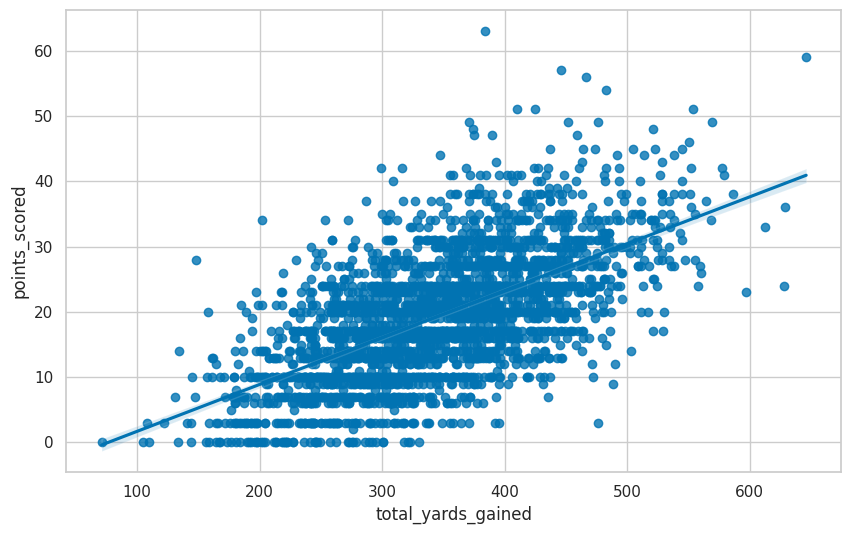

In [ ]:
sns.set_theme(style = 'whitegrid',
              palette = 'colorblind')
plt.figure(figsize=(10, 6))
sns.regplot(data = merged_pbp,
            x = 'total_yards_gained',
            y = 'points_scored'
            )
plt.show()

In [ ]:
performance = yards_to_points.predict(merged_pbp)

r_squared = yards_to_points.rsquared

mae = mean_absolute_error(merged_pbp['points_scored'], performance)

rmse = np.sqrt(mean_squared_error(merged_pbp['points_scored'], performance))

print(f"R-Squared: {r_squared}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

R-Squared: 0.3790327421577905
MAE: 5.827168782090426
RMSE: 7.428380438010194


##C**omparison**##
**The MLR Model is a better predictor in all 3 categories, but not significantly better**

**MLR MODEL:**

R-Squared: 0.468

MAE: 5.472

RMSE: 7.012


**SIMPLE LINEAR REGRESSION MODEL:**

R-Squared: 0.379

MAE: 5.827

RMSE: 7.428

##**In-Season Predictions**##

In [ ]:
# pull in 2024 season averages
team_avg_stats = pd.DataFrame({
    'posteam': ['MIA', 'NE', 'PIT', 'DAL', 'HOU', 'BUF', 'DEN', 'LV', 'WAS', 'CLE', 'CHI', 'CAR', 'TB', 'ATL', 'SF', 'ARI'],
    'avg_passing_yards': [187.3, 112.3, 189.3, 255.5, 257.8, 195.5, 159.8, 212.5, 213.0, 151.5, 165.8, 182.5, 223.0, 206.5, 271.5, 179.8],
    'avg_rushing_yards': [97.8, 126.5, 128.5, 75.3, 106.8, 110.3, 106.3, 76.3, 169.3, 94.8, 87.3, 108.5, 96.0, 102.8, 141.8, 153.3],
    'avg_total_plays': [65.0, 59.0, 62.8, 64.4, 67.0, 55.8, 60.6, 59.6, 62.8, 62.8, 65.2, 59.8, 57.8, 59.2, 65.0, 58.0],
    'avg_total_turnovers': [1.0, 1.0, 0.8, 0.8, 1.0, 0.5, 1.8, 1.5, 0.3, 1.3, 1.5, 1.3, 0.8, 1.3, 1.3, 1.0],
    'avg_sacks_allowed': [3.3, 4.3, 2.5, 2.5, 3.5, 1.3, 1.0, 3.5, 2.3, 4.8, 4.0, 2.0, 3.8, 1.5, 2.8, 2.5]
})

In [ ]:
# Use a copy to avoid modifying the original df
prediction_data = team_avg_stats.copy()

prediction_data = prediction_data.rename(columns={
    'avg_passing_yards': 'total_passing_yards',
    'avg_rushing_yards': 'total_rushing_yards',
    'avg_total_plays': 'total_plays',
    'avg_total_turnovers': 'total_turnovers',
    'avg_sacks_allowed': 'sacks_allowed'
})

prediction_data['predicted_points'] = train_model.predict(prediction_data)

In [ ]:
# Dictionary for my teams' matchups
matchups = {
    'MIA': 'NE',
    'PIT': 'DAL',
    'HOU': 'BUF',
    'DEN': 'LV',
    'WAS': 'CLE',
    'CHI': 'CAR',
    'TB': 'ATL',
    'SF': 'ARI'
}

prediction_data = pd.DataFrame()

for team in matchups.keys():
    team_stats = team_avg_stats[team_avg_stats['posteam'] == team]
    # Adding 'posteam' to the selected columns:
    prediction_data = pd.concat([prediction_data, team_stats[['posteam',
        'avg_passing_yards', 'avg_rushing_yards', 'avg_total_plays',
        'avg_total_turnovers', 'avg_sacks_allowed']]], ignore_index=True)

for team in matchups.values():
    team_stats = team_avg_stats[team_avg_stats['posteam'] == team]
    # Adding 'posteam' to the selected columns:
    prediction_data = pd.concat([prediction_data, team_stats[
        ['posteam', 'avg_passing_yards', 'avg_rushing_yards', 'avg_total_plays',
        'avg_total_turnovers', 'avg_sacks_allowed']]], ignore_index=True)

# Rename again (Gemini told me to)
prediction_data = prediction_data.rename(columns={
    'avg_passing_yards': 'total_passing_yards',
    'avg_rushing_yards': 'total_rushing_yards',
    'avg_total_plays': 'total_plays',
    'avg_total_turnovers': 'total_turnovers',
    'avg_sacks_allowed': 'sacks_allowed'
})

# Predict
prediction_data['predicted_points'] = train_model.predict(
    prediction_data[['total_passing_yards', 'total_rushing_yards',
                     'total_plays', 'total_turnovers', 'sacks_allowed']])

In [ ]:
# List to store the predicted scores
matchup_results = []

# Iterate over the matchups and combine predictions for each game
for home_team, away_team in matchups.items():
    home_points = prediction_data[prediction_data['posteam'] == home_team]['predicted_points'].values[0]
    away_points = prediction_data[prediction_data['posteam'] == away_team]['predicted_points'].values[0]

    matchup_results.append({
        'Matchup': f"{home_team} vs {away_team}",
        'Home_Predicted_Score': home_points,
        'Away_Predicted_Score': away_points
    })

# Print in df form for formatting
results_df = pd.DataFrame(matchup_results)
print(results_df)

      Matchup  Home_Predicted_Score  Away_Predicted_Score
0   MIA vs NE             14.986827             12.614605
1  PIT vs DAL             19.343831             18.475231
2  HOU vs BUF             20.395621             20.199966
3   DEN vs LV             15.172209             14.494463
4  WAS vs CLE             25.876903             10.925165
5  CHI vs CAR             11.210603             16.985863
6   TB vs ATL             18.127623             18.557551
7   SF vs ARI             25.226832             21.503254


**RESULTS**

MIA vs NE:  15-10

PIT vs DAL: 17-20

HOU vs BUF: 23-20

DEN vs LV:  34-18

WAS vs CLE: 34-13

CHI vs CAR: 36-10

TB vs ATL:  30-36

SF vs ARI:  23-24

- My MLR model using the features that I chose is far from a reliable predictor for forecasting points scored, but it did perform slightly better than the simple linear regression model which I'll take as a win I guess

- It was interesting to see that, while splitting hairs, the model does assess a rushing yard as being a more positive impact than a passing yard

- I found that the correlation between giving up a sack and it hurting the expected point total was greater than I anticipated

- Lastly, I found it interesting (and it makes sense) how the model assessed that running more plays in a game has a negative impact on ultimately scoring points

  - a quick, explosive offense is more likely to put up more points than a slow, grind-it-out, wear you down offense.
  - That's not to say that a quick and explosive offense is better; there are undoubtedly side effects to an explosive offense felt by the defensive side